In [1]:
import numpy as np
import matplotlib.pyplot as plt
import model_base as mb
from experiments import get_null_ff_input_arrays

In [26]:
# define parameter dictionaries
N_cells, w_mean, conn_prob, bg_inputs, taus = mb.get_default_params(flag_mean_pop=True)

# LH predictive coding params:
w_mean_update = dict(EP=2, DE=0.5, DS=0.5, PE=1.2, PP=1, PS=0.3, PV=0.3, SE=1, SV=0.6, VE=1, VS=0.7)
w_mean_update = dict(EP=2, DE=0., DS=1, PE=1.2, PP=0.4, PS=0.3, PV=0.15, SE=1, SV=0.5, VE=1, VS=1)  # these work!

w_mean.update(w_mean_update)

# w_mean.update(dict(VE=0))

# instantiate model
model = mb.NetworkModel(N_cells, w_mean, conn_prob, taus, bg_inputs, wED=1, flag_w_hetero=False, flag_pre_inh=False, flag_with_NDNF=False, flag_with_VIP=True, flag_with_PV=True)

In [31]:
# simulation parameters
dur = 7000  # ms
dt = 1  # ms
t = np.arange(0, dur, dt)
nt = len(t)

# construct input: fully prediced, overpredicted, underpredicted
amp = 2
fp_s, fp_e = 1000, 2000
op_s, op_e = 3000, 4000
up_s, up_e = 5000, 6000

sensory = np.zeros(nt)
sensory[fp_s:fp_e] = amp
sensory[up_s:up_e] = amp

prediction = np.zeros(nt)
prediction[fp_s:fp_e] = amp
prediction[op_s:op_e] = amp

In [32]:
# set input of cells
xFF = get_null_ff_input_arrays(nt, N_cells)
xFF['E'] = np.tile(sensory, [N_cells['E'], 1]).T
xFF['D'] = np.tile(prediction, [N_cells['D'], 1]).T
xFF['P'] = np.tile(sensory, [N_cells['P'], 1]).T
xFF['S'] = np.tile(sensory, [N_cells['S'], 1]).T
xFF['V'] = np.tile(prediction, [N_cells['V'], 1]).T


In [33]:
# run network
t, rE, rD, rS, rN, rP, rV, p, cGABA, other = model.run(dur, xFF, dt=dt, rE0=1, rP0=4, rS0=4, rV0=4, rD0=0, p0=0.5, calc_bg_input=True)
print(model.Xbg)
t = t/1000

{'E': 9, 'D': 4.0, 'N': 0, 'S': 5.0, 'P': 6.199999999999999, 'V': 7}


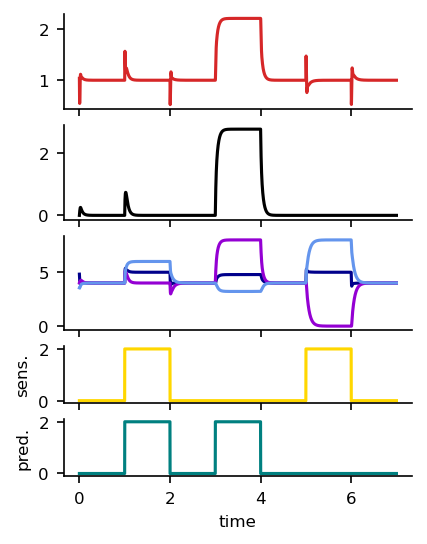

In [34]:
fig, ax = plt.subplots(5, 1, dpi=150, figsize=(3, 4), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 0.6, 0.6]})
ax[0].plot(t, rE, c='C3')
ax[1].plot(t, rD, c='k')
ax[2].plot(t, rP, c='darkblue')
ax[2].plot(t, rV, c='darkviolet')
ax[2].plot(t, rS, c='cornflowerblue')
ax[3].plot(t, sensory, c='gold')
ax[4].plot(t, prediction, c='teal')
ax[3].set(ylabel='sens.')
ax[4].set(ylabel='pred.', xlabel='time')
plt.show()